# Portfolio DAY 2

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://raw.githubusercontent.com/CALDISS-AAU/sdsphd20/master/datasets/turnover.csv')

In [64]:
# Encode the catagorical data
df = pd.get_dummies(df)

# Select the dependent and independent variables
y = df.loc[:, df.columns == 'churn']
X = df.loc[:, df.columns != 'churn']

# Transform the dataset to min-max
scaler = MinMaxScaler()
Xt = scaler.fit_transform(X)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.33, random_state=42, shuffle=True) # 42 for reproducability

In [66]:
classifier = RandomForestClassifier(n_estimators=200)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9872727272727273


In [67]:
# !! WARNING -- THIS TAKES 10~ MINUTES TO RUN!! (You can skip it, the next cells has the optimised parameters)
# Not really necessary as our model is already 99%~ accurate and properly won't improve. Done as an exercise.

# Lets tune the model (Integrated from Will Koersen @ Medium)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
}

classifier_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

classifier_random.fit(Xt, y)

classifier_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.3min finished


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [68]:
# Use the parameters from the RandomisedSearch tuning.
classifier = RandomForestClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred)) # Same accuracy as before, more or less as expected.

Accuracy: 0.9870707070707071


In [69]:
# Create a dataframe of the feature importance for the accuracy of the model.
feature_importances_df = pd.DataFrame(
    {
        "feature": list(X.columns),
        "importance": classifier.feature_importances_,
    }
).sort_values("importance", ascending=False) # Sort by descending

feature_importances_df

,feature,importance
0,satisfaction,0.316539
2,number_of_projects,0.178521
4,time_spend_company,0.177950
3,average_montly_hours,0.157975
1,evaluation,0.123828
5,work_accident,0.009429
18,salary_low,0.006894
17,salary_high,0.005829
19,salary_medium,0.003198
16,department_technical,0.003185


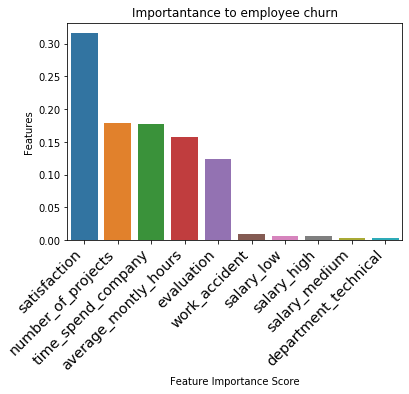

In [70]:
# Plot the top 1 contributors to employee churn.
sns.barplot(
    x=feature_importances_df.feature[:10],
    y=feature_importances_df.importance[:10],
)

# Improve visualisation
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Importantance to employee churn")
plt.xticks(
    rotation=45,
    horizontalalignment="right",
    fontweight="light",
    fontsize="x-large",
)
plt.show()

# Conclusion
Satisfaction seems to by far be the best indicator. Any features besides the top 5 are more or less redundant.